# Детекция сцен в фильме: туториал от ivi

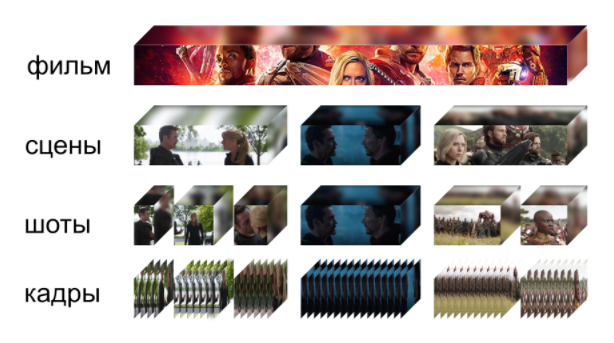

https://habr.com/ru/company/ivi/blog/497428/

https://github.com/ivi-ru/video-scene-detection

In [99]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import pickle

path = 'data'
os.listdir(path)

4.0


['Zombieland.mkv', 'Zombieland2.avi']

PySceneDetect режет видео на шоты, а не на сцены (c) ivi

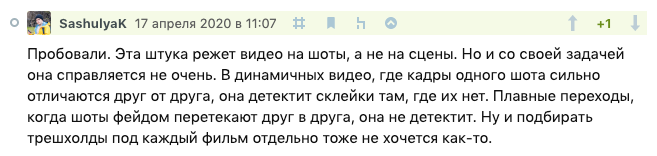



# 1. Детекция шотов

### Command line SceneDetect

- позволяет выбрать трешхолд <code>detect-content --threshold 33</code> (default is 30)
- начало <code>--start 00:00:00</code> 
- продолжительность <code>--duration 300s</code>
- сохранить 2 картинки начала и конца шота <code>save-images --num_images 2 -o pyscene_output/zombieland/img </code>
- html-таблица списка шотов с длительностью и картинками <code>export-html</code>

<code>>>> scenedetect -i /data/dfs2/video_analytics/data/Zombieland2.avi -s video.stats.csv detect-content --threshold 33 list-scenes time --start 00:00:00 --end 01:39:01 save-images --num-images 2 -o pyscene_output/zombieland/img export-html
</code>

### Посмотрим на размеченные шоты
- scenedetect отдает нам сейчас по 2 картинки на шот
- используем сортировку по времени создания, а не по названию для надежности

Zombieland2-Scene-0006-01.jpg


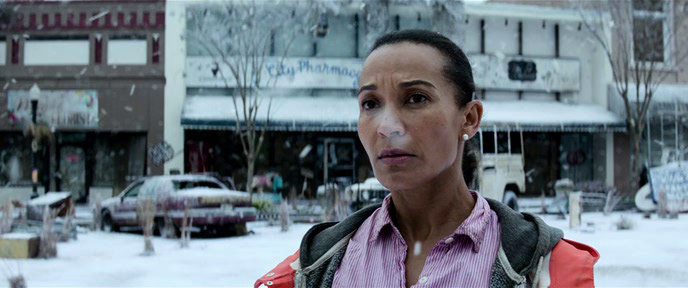

Zombieland2-Scene-0006-02.jpg


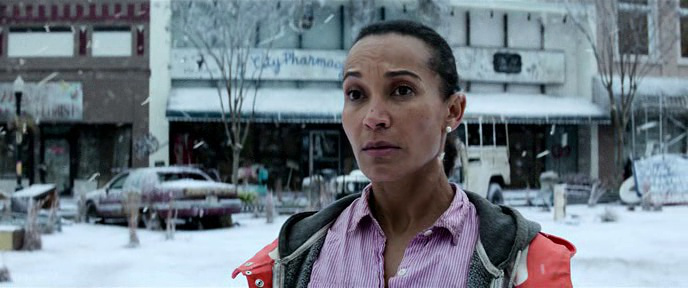

Zombieland2-Scene-0007-01.jpg


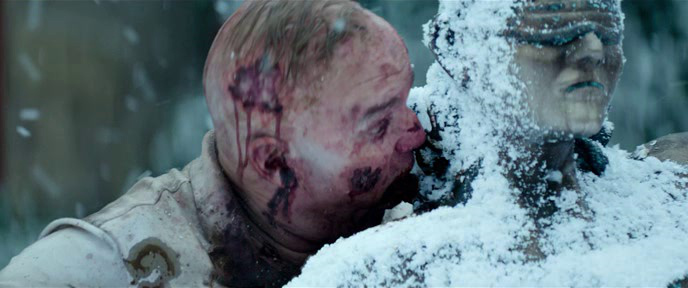

Zombieland2-Scene-0007-02.jpg


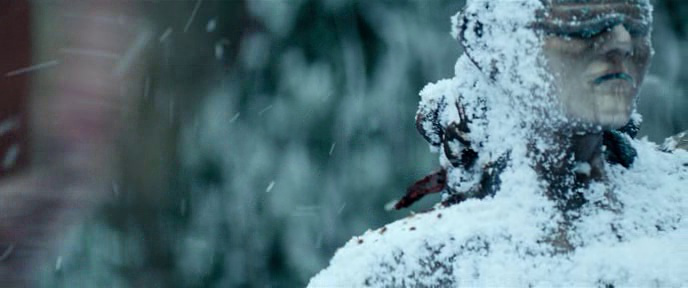

Zombieland2-Scene-0008-01.jpg


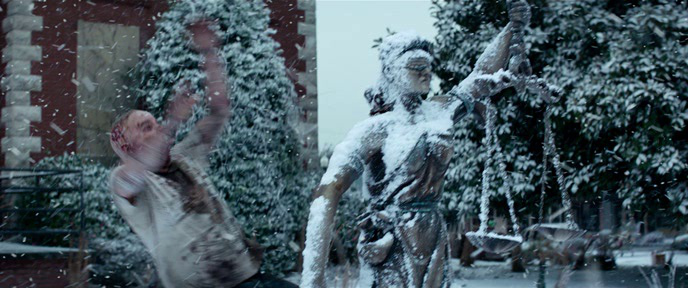

Zombieland2-Scene-0008-02.jpg


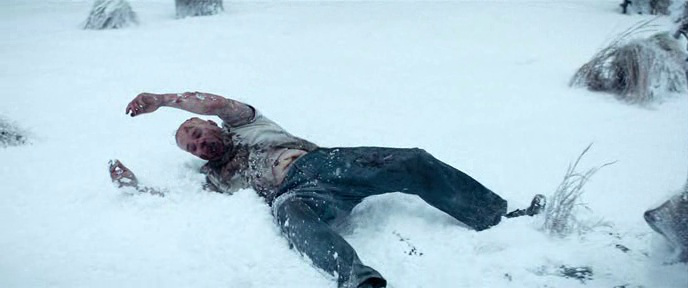

Zombieland2-Scene-0009-01.jpg


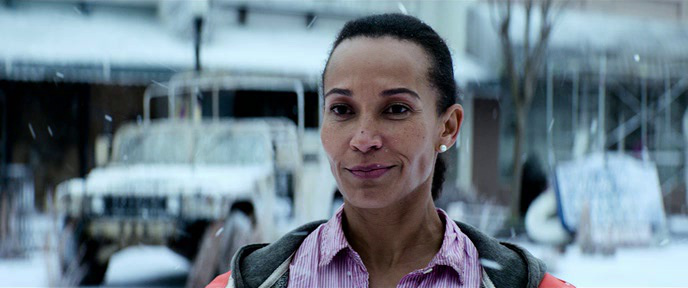

Zombieland2-Scene-0009-02.jpg


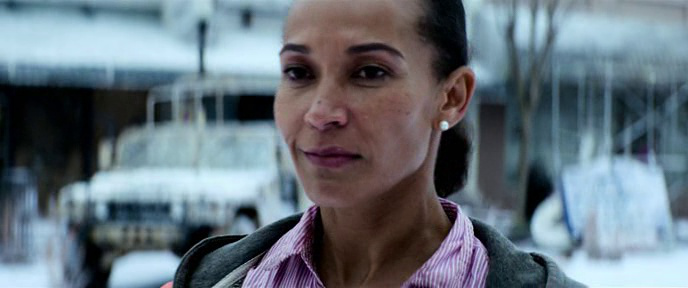

Zombieland2-Scene-0010-01.jpg


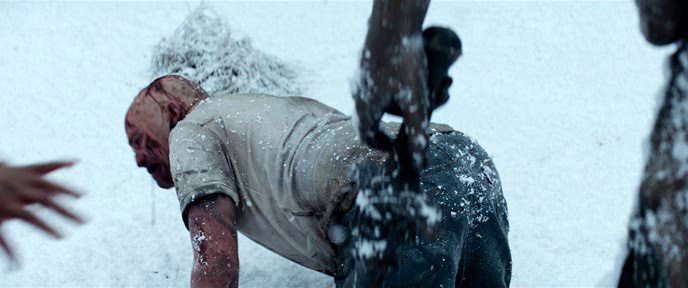

Zombieland2-Scene-0010-02.jpg


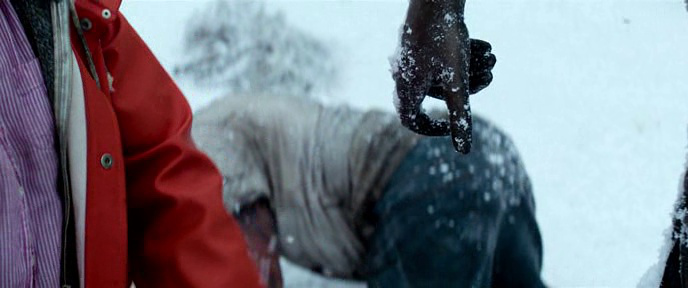

Zombieland2-Scene-0011-01.jpg


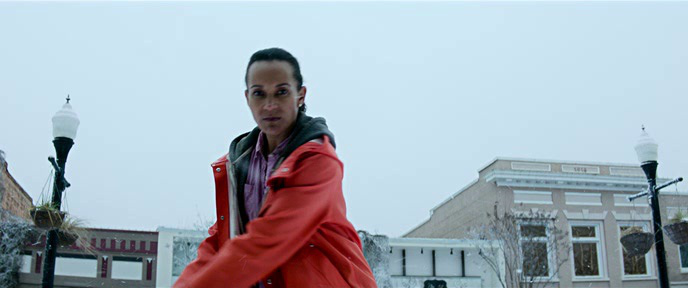

Zombieland2-Scene-0011-02.jpg


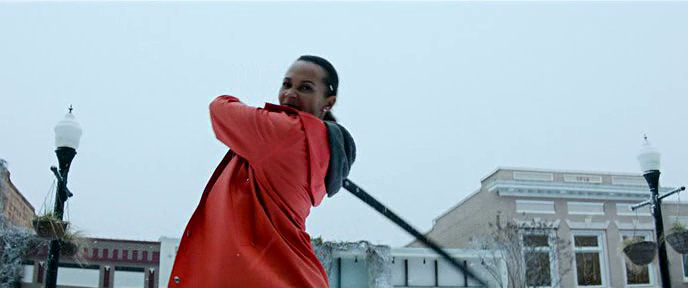

Zombieland2-Scene-0012-01.jpg


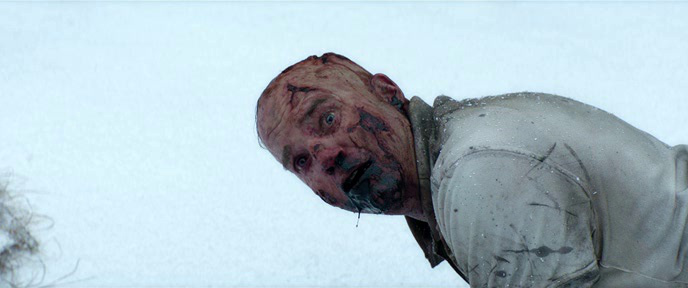

Zombieland2-Scene-0012-02.jpg


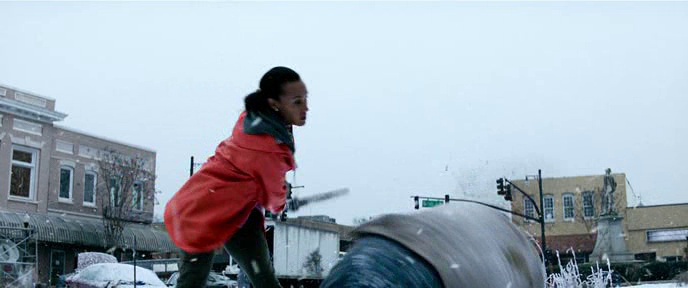

Zombieland2-Scene-0013-01.jpg


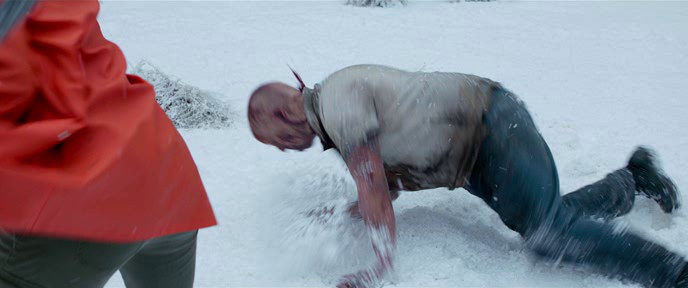

Zombieland2-Scene-0013-02.jpg


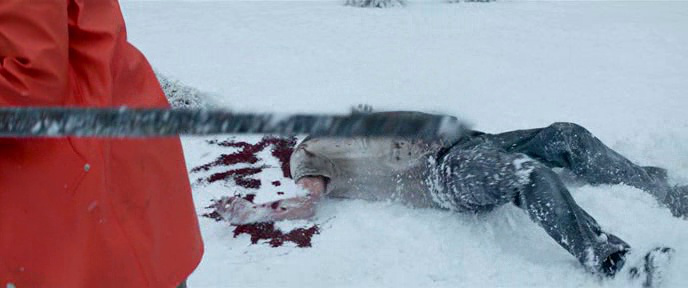

Zombieland2-Scene-0014-01.jpg


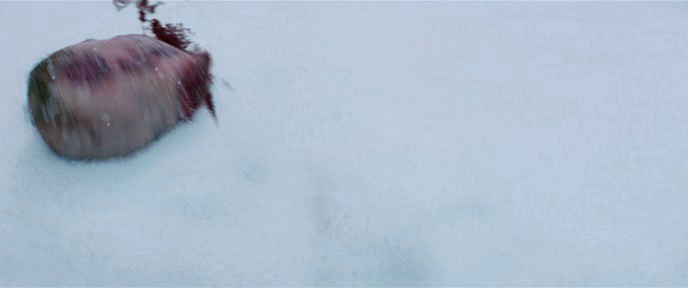

Zombieland2-Scene-0014-02.jpg


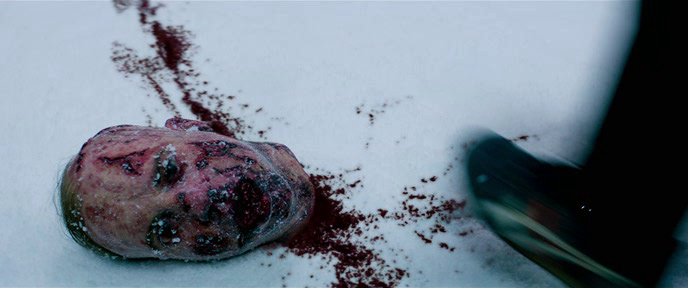

Zombieland2-Scene-0015-01.jpg


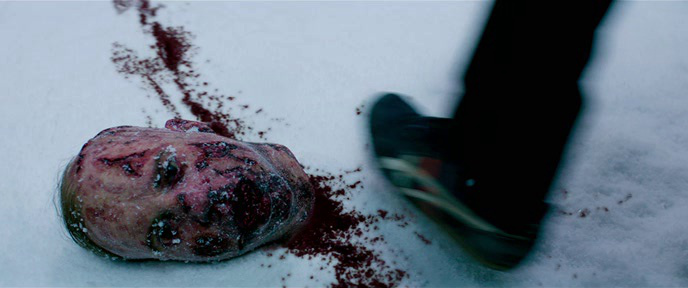

Zombieland2-Scene-0015-02.jpg


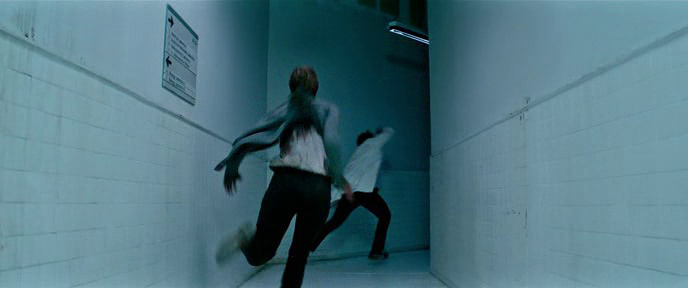

In [106]:
from PIL import Image

output_path = "/pyscene_output/zombieland/img"

for img_path in sorted(Path(output_path).iterdir(), key=os.path.getmtime)[10:30]:
    if '.jpg' in img_path.name:
        print(img_path.name)
        display(Image.open(f"{img_path}"))

### Сохранение списка шотов - shot dict

- вся статистика по началу и концу шотов в frame и seconds сохраняется в csv

In [107]:
df = pd.read_csv('Zombieland2-Scenes.csv', skiprows=1)\
    .set_index('Scene Number')

df['frame_list'] = [list(p) for p in zip(df['Start Frame'].values, df['End Frame'].values)]

In [108]:
print(df.shape)
df.head()

(1978, 10)


Start Frame Start Timecode  Start Time (seconds)  End Frame  \
Scene Number                                                                
1                       0   00:00:00.000                 0.000        987   
2                     987   00:00:41.166                41.166       1092   
3                    1092   00:00:45.546                45.546       1966   
4                    1966   00:01:21.999                81.999       2038   
5                    2038   00:01:25.002                85.002       2103   

              End Timecode  End Time (seconds)  Length (frames)  \
Scene Number                                                      
1             00:00:41.166              41.166              987   
2             00:00:45.546              45.546              105   
3             00:01:21.999              81.999              874   
4             00:01:25.002              85.002               72   
5             00:01:27.713              87.713               65   

             Length (timecode)  Length (seconds)    frame_list  
Scene Number                                                    
1                 00:00:41.166            41.166      [0, 987]  
2                 00:00:04.379             4.379   [987, 1092]  
3                 00:00:36.453            36.453  [1092, 1966]  
4                 00:00:03.003             3.003  [1966, 2038]  
5                 00:00:02.711             2.711  [2038, 2103]

In [111]:
shot_dict = df['frame_list'].to_dict()

In [112]:
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
save_obj(shot_dict, 'shot_dict')

# 2. Расчет расстояний между шотами

- получаем эмбеддинги одной картинки из каждого шота из предобученной Xception
- считаем матрицу попарных расстояний

### Keras Xception + картинки из шотов

In [113]:
import tensorflow as tf
from tensorflow.keras.applications.xception import decode_predictions

In [114]:
model = tf.keras.applications.xception.Xception(weights='imagenet', include_top=True)

model.summary()

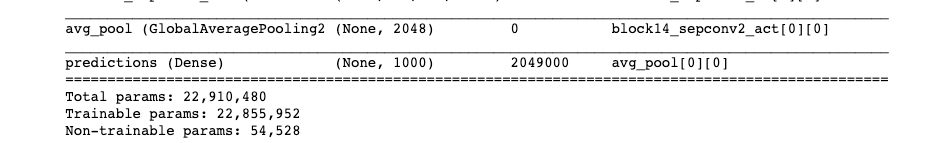

In [115]:
penult_layer_model = tf.keras.Model(inputs=model.input, 
                                    outputs=model.layers[-2].output)

Пример 

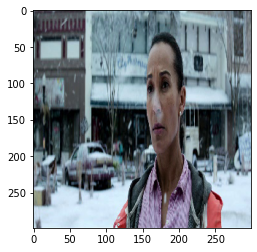

In [117]:
# loading and preprocessing image

IMAGE_PATH=f"{output_path}/Zombieland2-Scene-0006-01.jpg"
img = tf.keras.preprocessing.image.load_img(IMAGE_PATH,target_size=(299, 299))
img = tf.keras.preprocessing.image.img_to_array(img)

plt.imshow(img / 255.)

In [118]:
decode_predictions(model.predict(np.array([img])))

[[('n03942813', 'ping-pong_ball', 0.9999038),
  ('n03775546', 'mixing_bowl', 9.520224e-05),
  ('n04380533', 'table_lamp', 5.55979e-07),
  ('n03763968', 'military_uniform', 2.3282014e-07),
  ('n04149813', 'scoreboard', 1.5704858e-07)]]

In [119]:
len(penult_layer_model.predict(np.array([img]))[0])

2048

### Эмбеддинги картинок с предиктов предпоследнего слоя

In [120]:
img_embeddings = []

for img_path in tqdm(sorted(Path(output_path).iterdir(), key=os.path.getmtime)):
    if '-01.jpg' in img_path.name:
        img = tf.keras.preprocessing.image.load_img(f"{output_path}/{img_path.name}", target_size=(299, 299))
        img = tf.keras.preprocessing.image.img_to_array(img)
        img_embeddings.append(penult_layer_model.predict(np.array([img]))[0])

100%|██████████| 3956/3956 [04:33<00:00, 14.49it/s]


In [121]:
assert len(img_embeddings) == df.shape[0]

### Попарные расстояния между картинками

In [124]:
from scipy.spatial.distance import pdist, squareform

In [125]:
# вектор
distances = pdist(np.array(img_embeddings), metric='euclidean')

In [126]:
# матрица
dist_cube = squareform(distances)
dist_cube.shape

(1978, 1978)

# 3. Детекция сцен

### Расчет примерного кол-ва сцен

- с помощью расчета сингулярных значений для матрицы попарных расстояний
- но на это сверху придется накинуть эвристики

https://github.com/ivi-ru/video-scene-detection/blob/master/estimate_scenes_count.py

In [127]:
import numpy as np
from numpy.linalg import norm


def estimate_scenes_count(distance_matrix: np.ndarray) -> int:
    """
    Calculate approximate count of scenes.
    Get singular values of the distance_matrix and then - index of the "elbow value".
    :paran distance_matrix: matrix of the pairvaise distances between shots
    :return: estimated count of scenes
    """
    singular_values = np.linalg.svd(distance_matrix, full_matrices=False, compute_uv=False)
    singular_values = singular_values[:len(singular_values) // 2]
    singular_values = np.log(singular_values)

    start_point = np.array([0, singular_values[0]])
    end_point = np.array([len(singular_values), singular_values[-1]])
    max_distance = 0
    elbow_point = 0
    for i, singular_value in enumerate(singular_values):
        current_point = np.array([i, singular_value])
        distance = norm(np.cross(start_point - end_point, start_point - current_point)) / \
            norm(end_point - start_point)
        if distance > max_distance:
            max_distance = distance
            elbow_point = i
    return elbow_point


In [128]:
zombie_sc_cnt = estimate_scenes_count(dist_cube)
zombie_sc_cnt

89

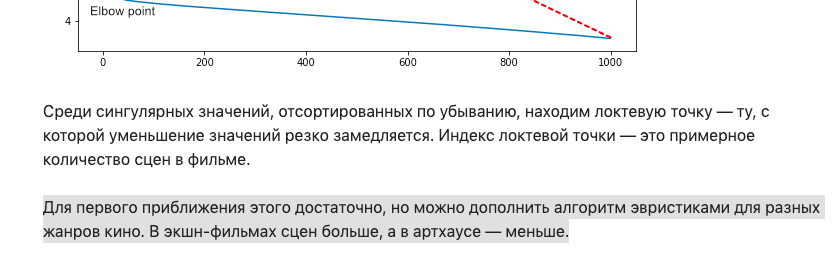

In [129]:
# эвристика от Дмитрия - сокращаем estimate_scenes_count на 30% 
zombie_sc_cnt = int(zombie_sc_cnt - np.floor(zombie_sc_cnt * 0.3))
zombie_sc_cnt

63

### Разобъем на сцены

https://github.com/ivi-ru/video-scene-detection/blob/master/h_add.py

In [137]:
"""Contains methods which help to split shots into scenes using the H_add cost function."""

import numpy as np


def get_optimal_sequence_add(distance_matrix: np.ndarray, scenes_count: int) -> np.ndarray:
    """
    Divide shots into scenes regarding to H_add metrics.
    More info in paper: https://ieeexplore.ieee.org/abstract/document/7823628
    :param distance_matrix: matrix of pairwise distances between shots
    :param scenes_count: number of resulting scenes
    :return: indexes of the last shot of each scene
    """
    D = distance_matrix
    K = scenes_count
    N = len(D)
    C = np.zeros((N, K))
    J = np.zeros((N, K), dtype=int)

    for n in range(0, N):
        C[n, 0] = np.sum(D[n:, n:])

    for n in range(0, N):
        J[n, 0] = N - 1

    for k in range(1, K):
        print(f"Scene number: {k} out of {K}")
        print("Shots count:")
        for n in tqdm(range(0, N)):
            candidates = []
            for i in range(n, N):
                if i < N - 1:
                    C_prev = C[i + 1, k - 1]
                else:
                    C_prev = 0
                h_n_i = np.sum(D[n:i + 1, n:i + 1])
                candidate = h_n_i + C_prev
                candidates.append(candidate)
            candidates = np.array(candidates)
            C[n, k] = np.min(candidates)
            J[n, k] = np.where(candidates == C[n, k])[0][0] + n

    t = np.zeros((K,), dtype=int)
    t_prev = 0
    for i in range(0, K):
        if i == 0:
            t_prev = 0
        else:
            t_prev = t[i - 1]
        t[i] = J[t_prev, K - i - 1]
    return t


Текущее время работы этого кода - несколько дней

TODO: ускорить

In [142]:
# hours estimation
dist_cube.shape[0] * zombie_sc_cnt / 60. / 60.

34.615

In [ ]:
zombie_sc = get_optimal_sequence_add(dist_cube, zombie_sc_cnt)

  0%|          | 0/1978 [00:00<?, ?it/s]

Scene number: 1 out of 63
Shots count:


  0%|          | 0/1978 [00:00<?, ?it/s]

Scene number: 2 out of 63
Shots count:


  0%|          | 0/1978 [00:00<?, ?it/s]

Scene number: 3 out of 63
Shots count:


  0%|          | 0/1978 [00:00<?, ?it/s]

Scene number: 4 out of 63
Shots count:


  0%|          | 0/1978 [00:00<?, ?it/s]

Scene number: 5 out of 63
Shots count:


  0%|          | 0/1978 [00:00<?, ?it/s]

Scene number: 6 out of 63
Shots count:


  0%|          | 0/1978 [00:00<?, ?it/s]

Scene number: 7 out of 63
Shots count:


  0%|          | 0/1978 [00:00<?, ?it/s]

Scene number: 8 out of 63
Shots count:


  0%|          | 0/1978 [00:00<?, ?it/s]

Scene number: 9 out of 63
Shots count:


 17%|█▋        | 343/1978 [29:17<1:33:29,  3.43s/it]

### Результат разбиения на сцены: 
- это номер последнего шота в сцене

In [145]:
zombie_sc

array([  15,   32,   51,   84,  121,  152,  184,  207,  231,  251,  287,
        320,  359,  400,  427,  453,  474,  501,  531,  548,  565,  588,
        608,  630,  653,  681,  716,  753,  807,  841,  884,  923,  944,
        971, 1000, 1026, 1058, 1089, 1134, 1181, 1212, 1241, 1277, 1291,
       1327, 1356, 1396, 1435, 1480, 1516, 1549, 1565, 1601, 1643, 1674,
       1716, 1769, 1796, 1853, 1879, 1916, 1946, 1977])

In [146]:
with open('zombie_sc.pkl', 'wb') as f:
    pickle.dump(zombie_sc, f)

### Вытащим номер фрейма для каждой сцены

In [152]:
scene_dict = df.loc[zombie_sc]['frame_list'].to_dict()

In [153]:
save_obj(scene_dict, 'scene_dict')